# Deep Learning with PyTorch: Dance Move Detector  
Course: CS506 Team Project  
Assignment: Submission #3  
Topic: Pose-based Dance Move Classification using CNN  
Team Members: Veronica Elze, Hiromi Cota, & Ixius Procopios

# 🧩 STEP 0: Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
import os
from pandas import DataFrame    # To create visualization

# Reuse logic from previous submissions
from pose_tools_byH import poses_to_vectors

# 📥 STEP 1: Load and Prepare Dataset

In [2]:
class DancePoseDataset(Dataset):
    def __init__(self, poses_dir):
        self.samples = []
        self.keypoints = []
        self.labels = []
        self.label_dict = {}
        files = [f for f in os.listdir(poses_dir) if f.endswith('.json')]
        for idx, f in enumerate(files):
            label_name = f.split('_')[0]  # Extract label from filename
            if label_name not in self.label_dict:
                self.label_dict[label_name] = len(self.label_dict)

            try:
                with open(os.path.join(poses_dir, f), 'r') as file:
                    data = json.load(file)
                keypoints = data[0]['people'][0]['pose_keypoints_2d']
                keypoints_array = np.array(keypoints).reshape(-1, 3)[:, :2]
                self.samples.append(keypoints_array.flatten())
                self.keypoints.append(keypoints_array)
                self.labels.append(self.label_dict[label_name])
            except Exception as e:
                print(f"Skipping file {f} due to error: {e}")

        # Standardize features
        self.scaler = StandardScaler()
        self.samples = self.scaler.fit_transform(self.samples)
        self.samples = torch.tensor(self.samples, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        # Visualization: Sample distribution
        self.visualize_sample_distribution()

    def visualize_sample_distribution(self):
        labels, counts = np.unique(self.labels.numpy(), return_counts=True)
        plt.bar(labels, counts, tick_label=[label for label, idx in self.label_dict.items()])
        plt.title("Distribution of Dance Pose Samples")
        plt.xlabel("Dance Pose")
        plt.ylabel("Count")
        plt.show()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx], self.keypoints[idx]

# 🧠 STEP 2: Define Neural Network (CNN)

In [3]:
class DanceNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DanceNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# 🎯 STEP 3: Train the Network

In [4]:
def train(model, dataloader, criterion, optimizer, epochs=20):
    loss_values = []
    for epoch in range(epochs):
        epoch_loss = 0
        for x, y, _ in dataloader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
        loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        
        # Interim Loss Visualization every 5 epochs
        if (epoch + 1) % 5 == 0:
            plt.plot(loss_values, color='blue', linestyle='--', alpha=0.6)
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Training Loss Curve (Epoch {epoch+1})")
            plt.grid(True)
            plt.show()
            
    return loss_values

# 🔍 STEP 4: Evaluate the Model

In [5]:
def evaluate(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y, _ in dataloader:
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(len(set(all_labels)))))
    disp.plot()
    plt.title(f'Confusion Matrix (Accuracy: {acc:.2%})')
    plt.show()

# 📊 STEP 5: Plot Loss Curve

In [6]:
def plot_loss_curve(losses):
    plt.figure(figsize=(10,6))
    plt.plot(losses, color='red', linewidth=2.5, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("FINAL Training Loss Curve", fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.show()

# 💃 STEP 6: Visualize Actual Poses

In [7]:
def visualize_pose(keypoints, title):
    plt.figure()
    plt.scatter(keypoints[:, 0], keypoints[:, 1])
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

# 🚀 STEP 7: Main Execution Block

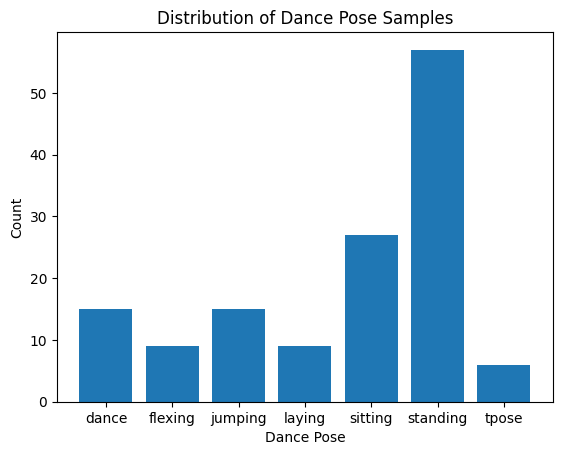

Epoch 1/20, Loss: 1.7349
Epoch 2/20, Loss: 1.3051
Epoch 3/20, Loss: 1.0674
Epoch 4/20, Loss: 0.9280
Epoch 5/20, Loss: 0.8064


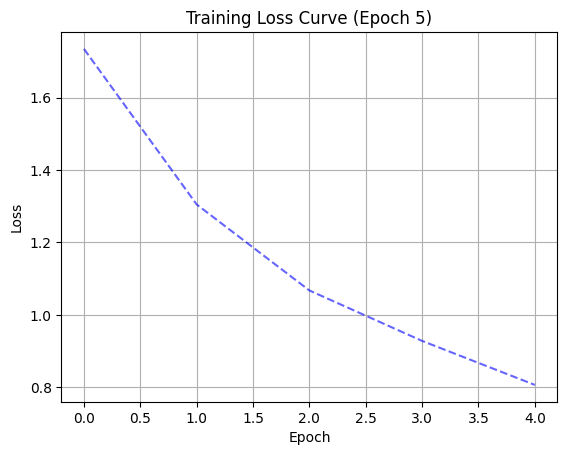

Epoch 6/20, Loss: 0.6801
Epoch 7/20, Loss: 0.5915
Epoch 8/20, Loss: 0.5166
Epoch 9/20, Loss: 0.4473
Epoch 10/20, Loss: 0.3900


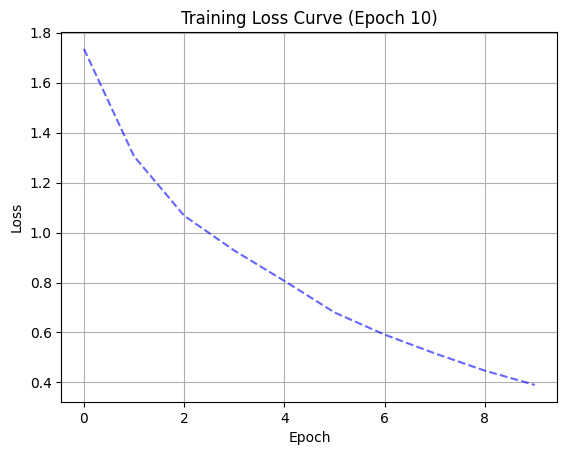

Epoch 11/20, Loss: 0.3316
Epoch 12/20, Loss: 0.2879
Epoch 13/20, Loss: 0.2496
Epoch 14/20, Loss: 0.2189
Epoch 15/20, Loss: 0.1874


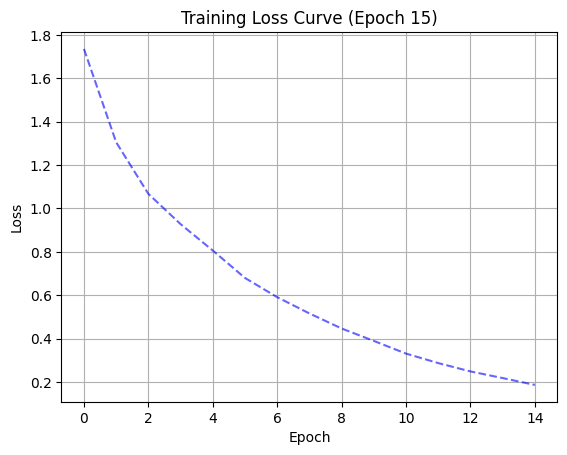

Epoch 16/20, Loss: 0.1694
Epoch 17/20, Loss: 0.1480
Epoch 18/20, Loss: 0.1260
Epoch 19/20, Loss: 0.1121
Epoch 20/20, Loss: 0.1004


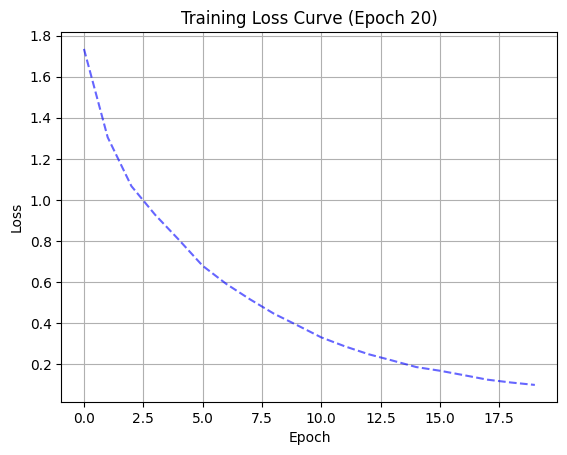

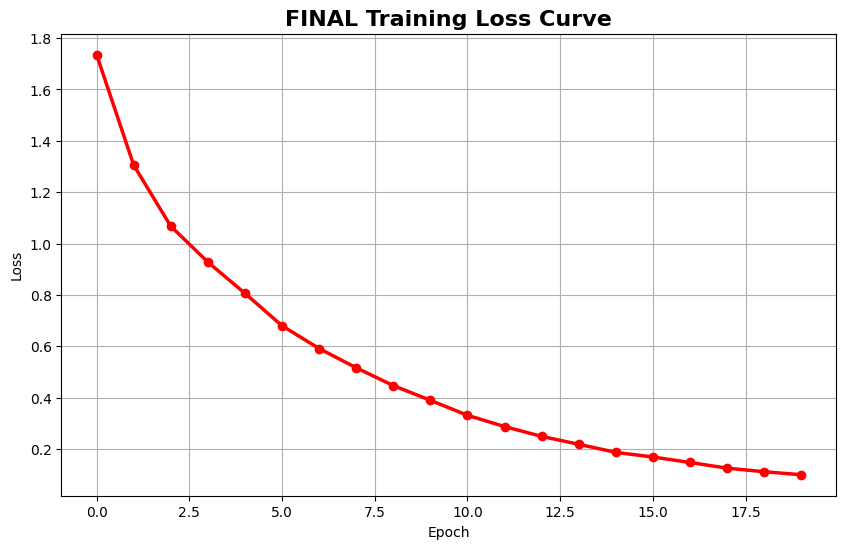

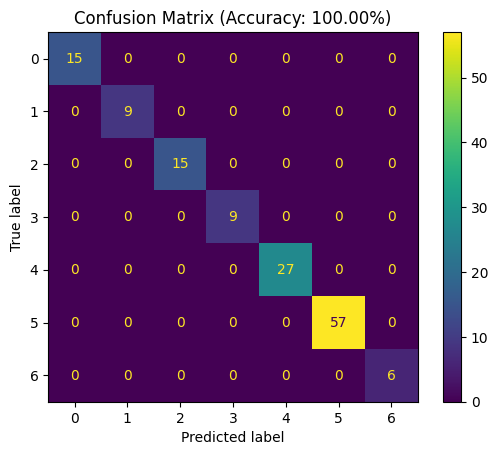

Model saved to sub3_dancemoves_model.pt


In [8]:
if __name__ == '__main__':
    poses_dir = Path("./poses")
    dataset = DancePoseDataset(poses_dir)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    input_size = dataset.samples.shape[1]
    num_classes = len(dataset.label_dict)

    model = DanceNet(input_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_history = train(model, dataloader, criterion, optimizer, epochs=20)

    plot_loss_curve(loss_history)
    evaluate(model, dataloader)

    model_save_path = Path("./sub3_dancemoves_model.pt")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

# 📽️ BONUS STEP: Visualizations

### All imports necessary for visualization

In [9]:
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from io import BytesIO

### Load pose data directly into PyTorch tensors

In [10]:
def read_pose_tensor(json_file, path="poses"):
    file_path = Path(path) / json_file
    with open(file_path) as file:
        data = json.load(file)
        points = data[0]["people"][0]["pose_keypoints_2d"]
        points_filtered = [p for i, p in enumerate(points) if (i+1) % 3 != 0]  # remove confidence scores
        pose_tensor = torch.tensor(points_filtered).view(-1, 2)
        return pose_tensor

### Calculate movement vectors using tensor arithmetic

In [11]:
def calculate_vectors_tensor(pose1, pose2):
    return pose2 - pose1

### Generate vector graph using tensor data

In [12]:
def generate_vector_graph_tensor(pose_tensor, movement_tensor, title):
    plt.figure(figsize=(8, 8))

    for i in range(pose_tensor.size(0)):
        x, y = pose_tensor[i]
        dx, dy = movement_tensor[i]
        plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=5, color='blue')

    plt.title(title)
    plt.grid(True)
    plt.axis('off')
    plt.gca().invert_yaxis()

    # Set explicit limits based on pose coordinates to avoid arrows going off-screen
    x_min, x_max = torch.min(pose_tensor[:, 0]) - 100, torch.max(pose_tensor[:, 0]) + 100
    y_min, y_max = torch.min(pose_tensor[:, 1]) - 100, torch.max(pose_tensor[:, 1]) + 100
    plt.xlim(x_min, x_max)
    plt.ylim(y_max, y_min)  # inverted y-axis

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    buf.seek(0)
    vector_img = plt.imread(buf)
    buf.close()

    return vector_img

### Side-by-side visualization of poses and vectors

In [13]:
def visualize_side_by_side(img1_path, img2_path, vector_img, pose1_label, pose2_label):
    img1 = plt.imread(img1_path)
    img2 = plt.imread(img2_path)

    fig, axarr = plt.subplots(1, 3, figsize=(20, 8))

    axarr[0].imshow(img1)
    axarr[0].set_title(pose1_label)
    axarr[0].axis('off')

    axarr[1].imshow(img2)
    axarr[1].set_title(pose2_label)
    axarr[1].axis('off')

    axarr[2].imshow(vector_img)
    axarr[2].set_title("Vector motion for poses")
    axarr[2].axis('off')

    plt.tight_layout()
    plt.show()

### Main Execution

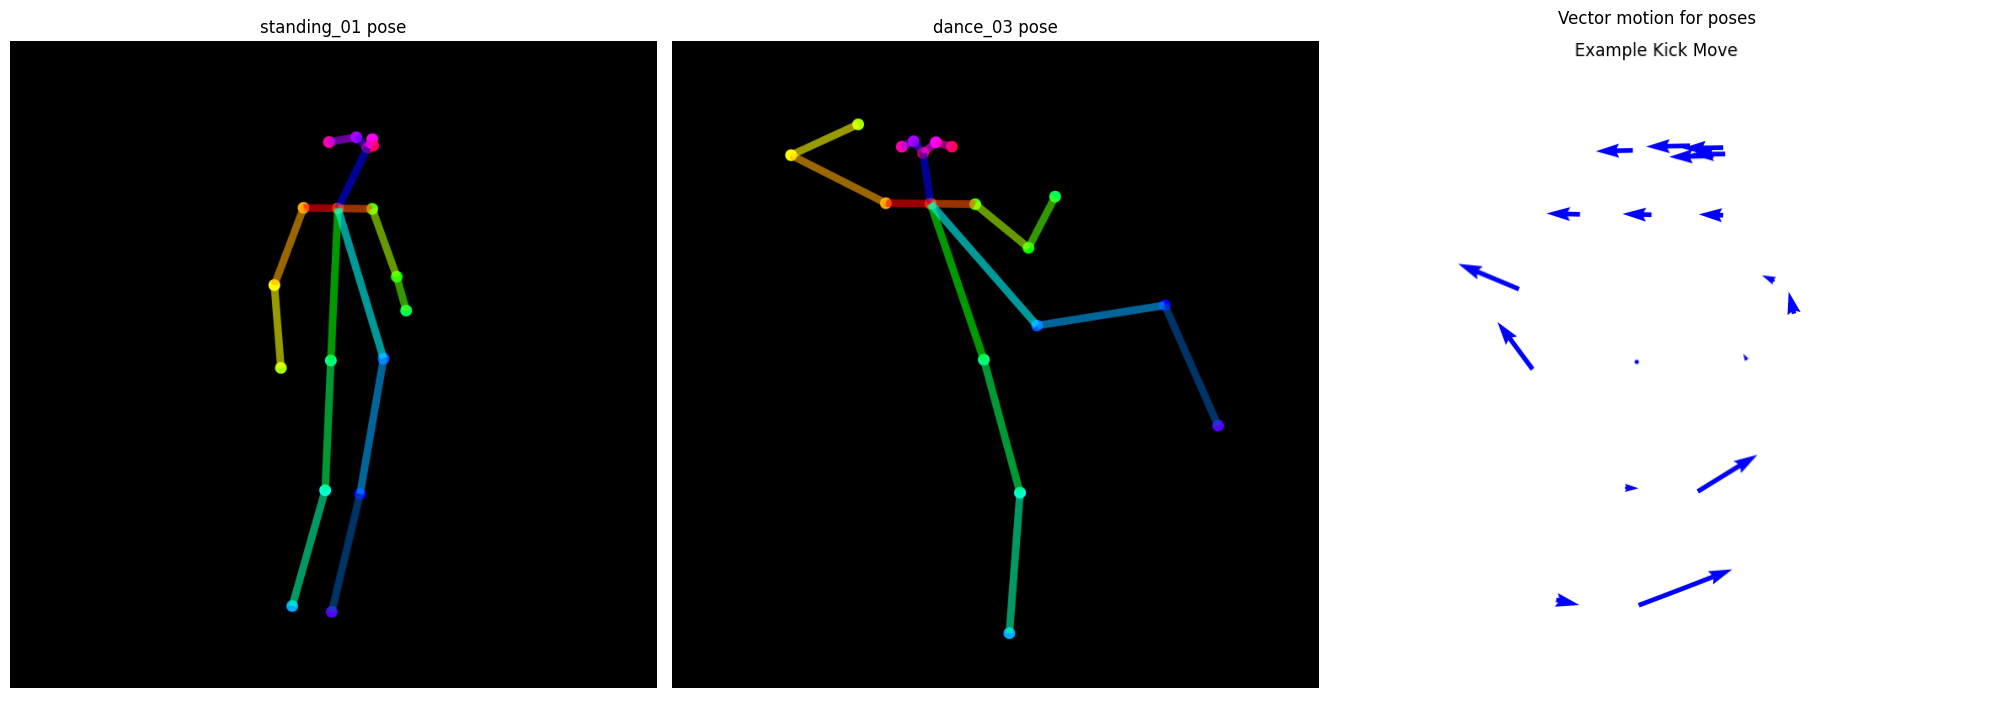

In [14]:
pose1_tensor = read_pose_tensor("standing_01.json")
pose2_tensor = read_pose_tensor("dance_03.json")

movement_tensor = calculate_vectors_tensor(pose1_tensor, pose2_tensor)

vector_img = generate_vector_graph_tensor(pose1_tensor, movement_tensor, "Example Kick Move")

img_dir = Path("submission1/post_images")
visualize_side_by_side(
    img_dir / "standing_01.png",
    img_dir / "dance_03.png",
    vector_img,
    "standing_01 pose",
    "dance_03 pose"
)

# REFERENCES 

OpenAI. (2025). ChatGPT’s assistance with CS506 TP03 Dance Detector [Large language model]. https://openai.com/chatgpt  
PyTorch. (n.d.). https://pytorch.org/docs/stable/index.html  
Scikit-Learn. (n.d.). StandardScaler, accuracy_score, confusion_matrix. https://scikit-learn.org/stable/modules/classes.html